In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from scipy.integrate import odeint

#keras = tf.keras
#tf.compat.v1.enable_eager_execution()

# from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [13]:
def SIRD_reduced_30_new(z, t, beta0, gamma, mu0, alpha):

    I, R, D = z
    
    S0 = 3.50860049e+01 * 100000 * beta0/10
    S = S0 - I - R - D
    mu = mu0/1000
    beta = beta0/10 * np.exp(-(alpha/1000) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma/100 * I - mu * I
    dR = gamma/100 * I
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIRD_reduced_30_new_ER(z, t, beta0, gamma, mu0, alpha):

    I, R, D = z
    
    S0 = 4.73028175e+01 * 100000 * beta0/10
    S = S0 - I - R - D
    mu = mu0/1000
    beta = beta0/10 * np.exp(-(alpha/1000) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma/100 * I - mu * I
    dR = gamma/100 * I
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt


def plot_traj_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]

    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Recovered')
    d = plt.plot(x4, linewidth = width, label = 'Deceased')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Real SIRD')
    plt.title('nCov-19 data, Italy')
    plt.tight_layout()
    plt.savefig('sir.png', dpi=500)
    
    
def plot_traj_gray_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')
    d = plt.plot(x4, linewidth = width, color = 'lightgray')

In [14]:
Region = 'Lombardia'

flag_r = (Region=='Lombardiaa')

import pandas as pd

if flag_r:
    italy = pd.read_csv('RegionLombardia.csv')
else:
    italy = pd.read_csv('RegionVeneto.csv')

In [15]:
italy.fillna(0, inplace = True)

In [16]:
ext = 53+10
eff = 53+10
start = 260
SIRD_flag = True
italy = italy[start:]
italy = italy[:ext]
italy.reset_index(inplace = True, drop = True)

In [17]:
data_size = italy.shape[0]

batch_time = 20 # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'I'],italy.loc[i,'R'],italy.loc[i,'D']])
    extended_y = np.array(extended_y)
else:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'I'],italy.loc[i,'R']+italy.loc[i,'D']])
    extended_y = np.array(extended_y)

nonorm_y = extended_y.copy()

In [18]:
italy = italy[:eff]
italy.reset_index(inplace = True, drop = True)
#italy

In [19]:
data_size = italy.shape[0]

batch_time = 15  # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'I'],italy.loc[i,'R'],italy.loc[i,'D']])
    true_y = np.array(true_y)
else:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'I'],italy.loc[i,'R']+italy.loc[i,'D']])
    true_y = np.array(true_y)

nonorm_y = true_y.copy()

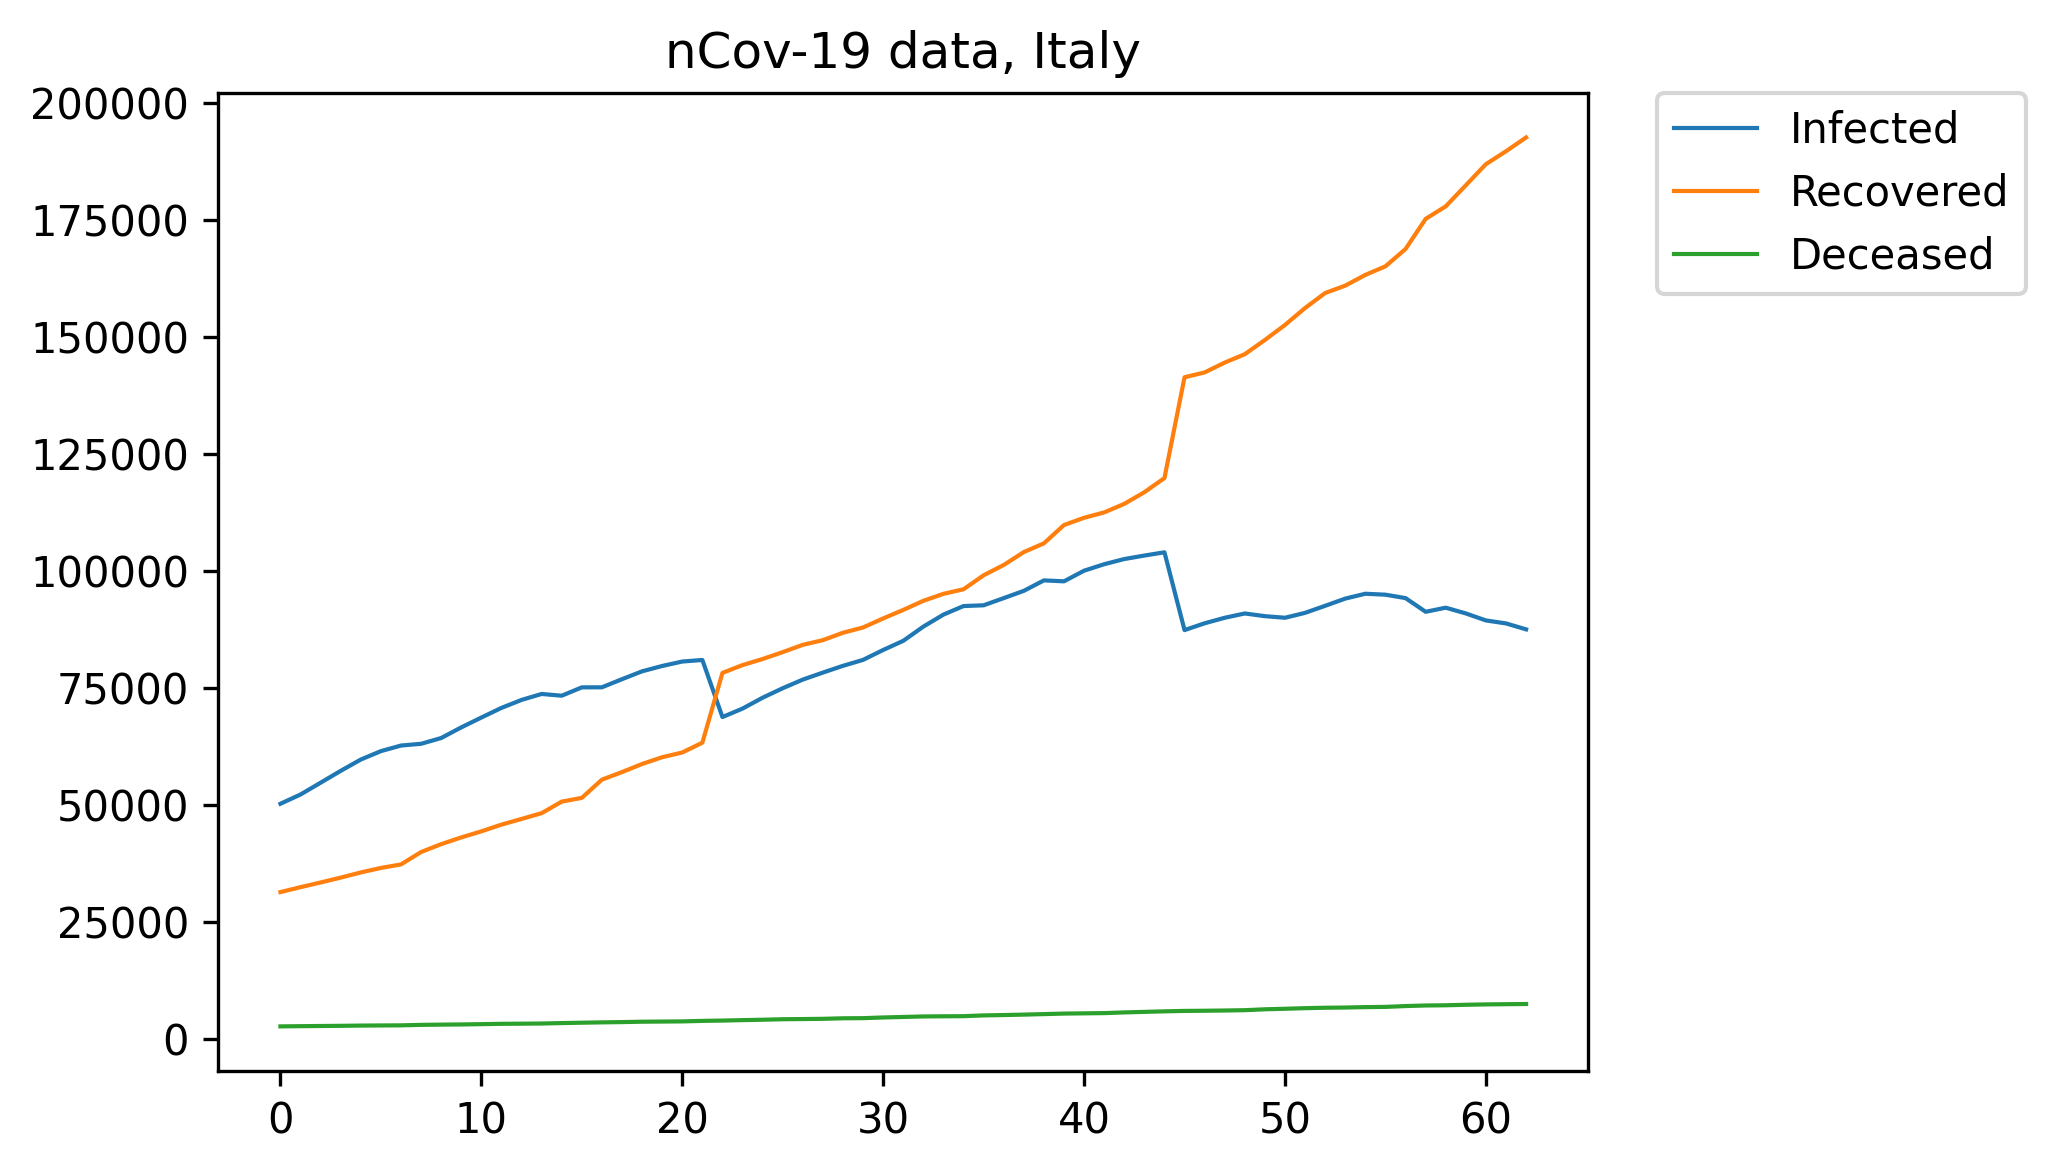

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4), dpi=150, facecolor='w', edgecolor='k')

plot_traj_SIRD(true_y)

In [21]:
china_start = np.float32(np.array(italy.iloc[0,0:4]))
print(china_start)

if flag_r:
    italy_start = tuple(china_start)
else:
    italy_start = tuple(china_start)
    
italy_start

[50250. 31362.  2643.]


(50250.0, 31362.0, 2643.0)

In [22]:
data_size = italy.shape[0]
t_grid = np.arange(data_size)

t_grid

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [23]:
from scipy import integrate, optimize

true_yy = np.append(true_y[:,0],true_y[:,1])
true_yy = np.append(true_yy,true_y[:,2])
    
def fit_odeint_reduced_30_new(x, beta0, gamma, mu0, alpha):
    fit = integrate.odeint(SIRD_reduced_30_new, italy_start, x, args=(beta0, gamma, mu0, alpha))
    fit_p = np.append(fit[:,0],fit[:,1])
    return np.append(fit_p,fit[:,2])

def fit_odeint_reduced_30_new_ER(x, beta0, gamma, mu0, alpha):
    fit = integrate.odeint(SIRD_reduced_30_new_ER, italy_start, x, args=(beta0, gamma, mu0, alpha))
    fit_p = np.append(fit[:,0],fit[:,1])
    return np.append(fit_p,fit[:,2])

if flag_r:
    popt, pcov = optimize.curve_fit(fit_odeint_reduced_30_new, xdata = t_grid, ydata =  true_yy, p0 = (0.43828327*10,  0.02015063*100,  0.30317892*10, 5), bounds=([0, 0, 0, -10], [10, 7, 5, 10]), method='trf')
else:
    popt, pcov = optimize.curve_fit(fit_odeint_reduced_30_new_ER, xdata = t_grid, ydata =  true_yy, p0 = (0.43828327*10,  0.02015063*100, 0.30317892*10, -5), bounds=([0, 0, 0, -30], [500, 7, 5, 100]), method='trf')

    
popt, pcov

(array([  0.7062179 ,   2.99197018,   0.94649065, -10.05706692]),
 array([[ 2.13366434e-04, -2.07373660e-04,  2.12505120e-04,
          2.88942312e-02],
        [-2.07373660e-04,  9.23251902e-04,  1.28718274e-04,
         -3.40670066e-02],
        [ 2.12505120e-04,  1.28718274e-04,  4.32771044e-02,
         -3.92162519e-02],
        [ 2.88942312e-02, -3.40670066e-02, -3.92162519e-02,
          4.14777038e+00]]))

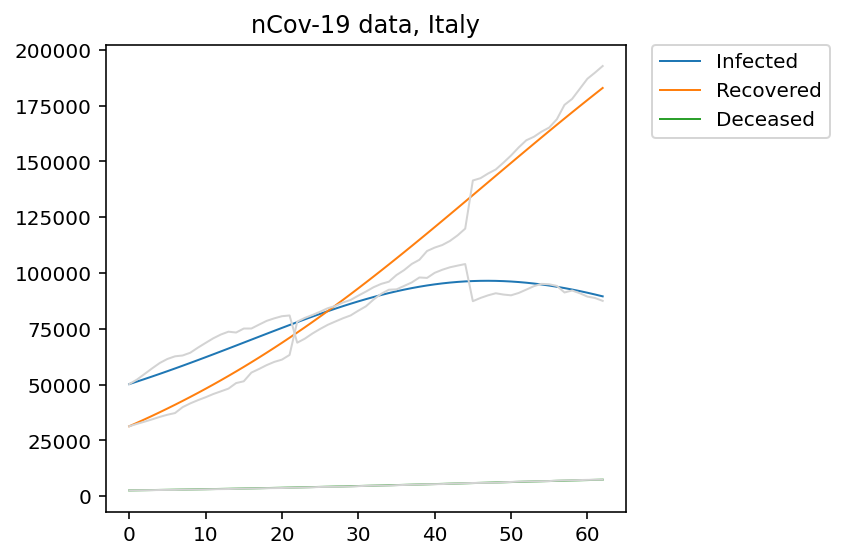

In [24]:
if flag_r:
    simul_yy =  odeint(SIRD_reduced_30_new, italy_start, np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIRD(simul_yy)
    plot_traj_gray_SIRD(extended_y)
    
else:
    simul_yy =  odeint(SIRD_reduced_30_new_ER, italy_start, np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIRD(simul_yy)
    plot_traj_gray_SIRD(extended_y)


In [25]:
extended_yy = np.append(extended_y[:,0],extended_y[:,1])
extended_yy = np.append(extended_yy,extended_y[:,2])

In [26]:
residuals = np.ravel(extended_yy) - fit_odeint_reduced_30_new_ER(np.arange(ext), *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((np.ravel(extended_yy)-np.ravel(np.mean(extended_yy)))**2)

r_squared = 1 - (ss_res / ss_tot)

r_squared 

0.9919022070519281

Text(0.5, 1.0, 'Correlation Matrix')

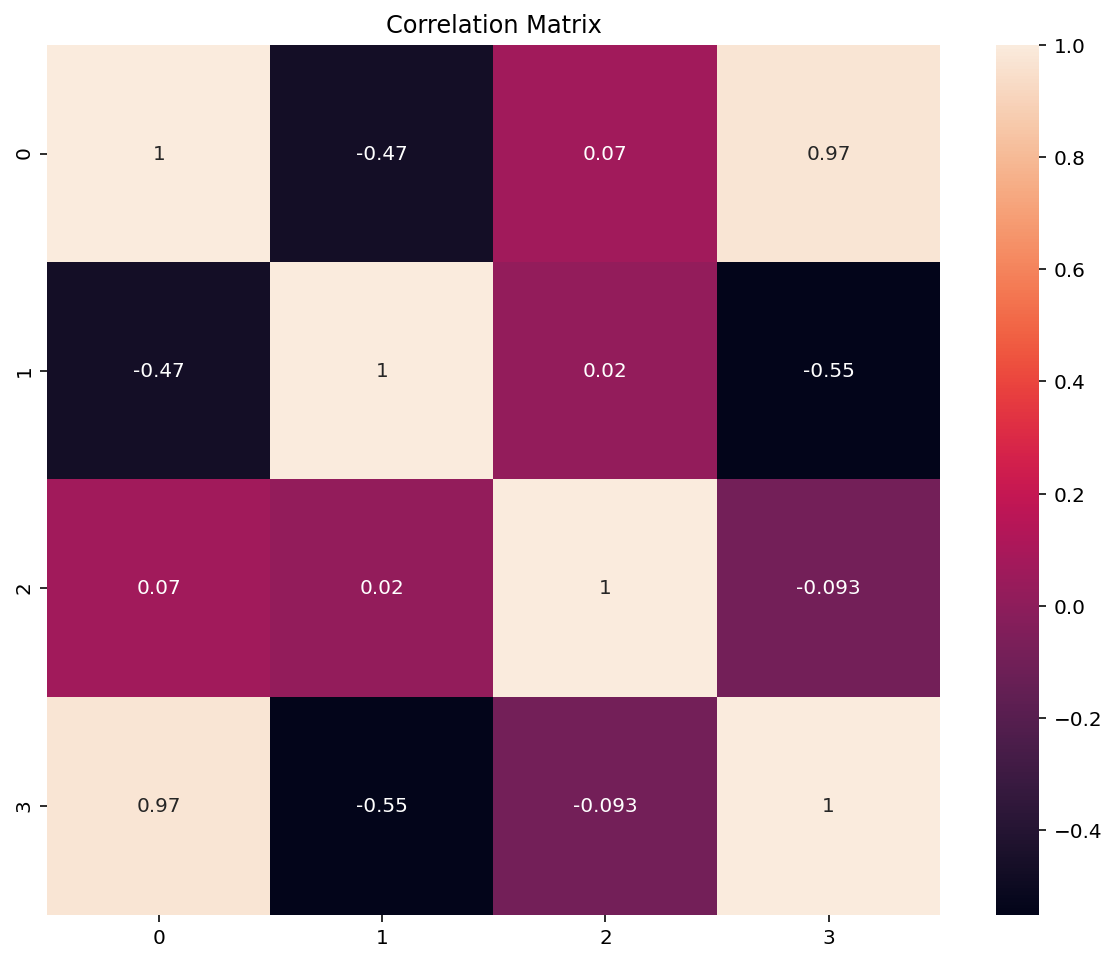

In [27]:
def compute_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

import seaborn as sns

corr = compute_corr(pcov)

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")


In [28]:
num_param = 4 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1



In [29]:
def compute_loss(params):
    residuals = true_yy - fit_odeint_reduced_30_new(np.arange(eff), *params)
    loss = np.sum(residuals**2)/(1e9)
    return loss

In [30]:
# These 2 functions sample from a truncated Gamma distribution by using the inverse cdf method. The first one
#  samples from the interval [a, +inf), the second one from [0, a)

import scipy.stats as sps
import numpy.random as npr

def trGamma_a_inf(shape, rate, trunc):
    interval = 1 - sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval + sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

def trGamma_0_a(shape, rate, trunc):
    interval = sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [97]:
def adaptive_gamma_sampling(true_center, shape, rate, quantile_1, quantile_2):
    if ((sps.gamma.cdf(true_center, a=shape, scale=1/rate) < quantile_1) | (sps.gamma.cdf(true_center, a=shape, scale=1/rate) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        loc = sps.gamma.mean(a=shape, scale=1/rate)
        if true_center > loc:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=trunc)
        else:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_0_a(shape=shape, rate=rate, trunc=trunc)
    else:
        w_temp = sps.gamma.rvs(a = shape, scale=1/rate)
    
    return(w_temp)


def border_estimates_e_abc(eps, niters):
    
    
    # This function estimates the borders of the region containing the eps-approximate posterior through niters 
    #  iterations. It uses the empirical sampling method to get nearer to the correct acceptance region.
    #  This is only used to estimate borders, though it can estimate also the parameters in order to avoid 
    #  biases in the estimation.

    import scipy.stats as sps

    initial_loss = 0
    
    naccepted = 0
    
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(num_param)
    
    prior_means = np.array([4.3828327, 2.015063, 9.293047 , 10])  # Estimations from Italy (Adjusted for alpha because of hard lockdown)
    
    for i in tqdm(range(niters)):

        lambda_temp = [npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 5)] #200

        alpha_quant = 0.25

        # Sampling of the candidate point from the priors
        
        w_temp[0] = adaptive_gamma_sampling(true_center=popt[0], shape=lambda_temp[0]*prior_means[0], rate=lambda_temp[0], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[1] = adaptive_gamma_sampling(true_center=popt[1], shape=lambda_temp[1]*prior_means[1], rate=lambda_temp[1], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[2] = adaptive_gamma_sampling(true_center=popt[2], shape=lambda_temp[2]*prior_means[2], rate=lambda_temp[2], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[3] = adaptive_gaussian_sampling(true_center=popt[3], loc=0, scale=lambda_temp[3], quantile_1=alpha_quant, quantile_2=1-alpha_quant)      
        
        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(w_temp)
        loss.append(sim_loss)
        
        # Acceptance condition

        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3) and all(w_temp[pos] >= 0 for pos in range(3)):  
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    
    borders = [np.min(parameters[:,i]) for i in range(num_param-1)]
    borders.append(np.max(parameters[:,(num_param-1)]))

    return(borders)

In [88]:
def e_abc_gamma_sampling(true_center, shape, rate, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    loc = sps.gamma.mean(a=shape, scale=1/rate)
    q = 0.25
    
    w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=border)
    
    return(w_temp)

In [89]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.25) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.75)):
        a = 0
        b = 0
        if (true_center > loc):
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [90]:
len(popt)

4

In [91]:
def preprocessing_e_abc(eps, niters, borders):

    # This function performs the first sampling from the region defined through the borders estimating function and
    #  returns the estimated parameters and the initializing weights, ([1,1,1,...,1] normalized)
    
    import scipy.stats as sps
    initial_loss = 0

    naccepted = 0

    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    prior_means = np.array([4.3828327, 2.015063, 9.293047 , 10])  # Estimations from Italy (Adjusted for alpha because of hard lockdown)
    
    for i in tqdm(range(niters)):

        lambda_temp = [npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 7)] 

        #w_temp = [e_abc_gamma_sampling(popt[j], lambda_temp[j]*prior_means[j], lambda_temp[j], borders[j]) for j in range(len(popt))]
        
        w_temp[0] = e_abc_gamma_sampling(true_center=popt[0], shape=lambda_temp[0]*prior_means[0], rate=lambda_temp[0], border=borders[0])
        w_temp[1] = e_abc_gamma_sampling(true_center=popt[1], shape=lambda_temp[1]*prior_means[1], rate=lambda_temp[1], border=borders[1])
        w_temp[2] = e_abc_gamma_sampling(true_center=popt[2], shape=lambda_temp[2]*prior_means[2], rate=lambda_temp[2], border=borders[2])
        w_temp[3] = e_abc_gaussian_sampling(true_center=popt[3], loc=0, scale=lambda_temp[3], border=borders[3])      
        
        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        #if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3) and (w_temp[3] >= 2*w_temp[2]):
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]

    weights = np.ones(parameters.shape[0])/parameters.shape[0]
    
    return(parameters, weights)

In [92]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    
    # This function computes the weights associated to each parameter as described in https://arxiv.org/pdf/1106.6280.pdf
    
    prob_w = 1
    for i in range(para_num):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(para_num):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)

def normalize_weights(weights):
    
    # This function performs the normalization of weights
    
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

def sample_abc_smc_element(parameters, weights):
    
    # This function samples from the previous population according to the specified weights
    
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

def perturbation_kernel(sdev):
    
    # This function returns the perturbation from a Gaussian kernel with the specified standard deviation
    
    return([np.random.randn()*sdev[i] for i in range(para_num)])

In [93]:
def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    # This function returns the sampling according to the ABC-SMC with the weights associated to old parameters
    # specified in weights and the old parameters specified in old_parameters
    
    import scipy.stats as sps

    initial_loss = 0

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        w_temp = np.resize(w_temp, (para_num,))

        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        #if (np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3)) and (min(w_temp) >= 0) and (w_temp[3] >= 2*w_temp[2]):
        if (np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3)) and (min(w_temp[0:3]) >= 0):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5) # CAMBIARE LA FUNZIONE CHE PRENDE IN INGRESSO
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        
    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)

In [98]:
import scipy.stats as sps

eps = 10*compute_loss(popt)
niters = 3000

print("Borders estimation start...")
borders = border_estimates_e_abc(eps, 1*niters)

  1%|▊                                                                              | 33/3000 [00:00<00:09, 321.23it/s]

Borders estimation start...


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 328.67it/s]

Acceptance rate:  0.208


In [99]:
borders

[0.2398643899661765,
 2.070123972370099,
 0.8456058641419995,
 -0.11444501601364016]

In [117]:
print(borders)
print("Borders estimation completed, starting preprocessing...")
start, start_weights = preprocessing_e_abc(eps/7, 50*niters, borders)
print("Preprocessing completed, starting ABC-SMC")

  0%|                                                                             | 31/150000 [00:00<08:15, 302.41it/s]

[0.2398643899661765, 2.070123972370099, 0.8456058641419995, -0.11444501601364016]
Borders estimation completed, starting preprocessing...


100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [08:12<00:00, 304.51it/s]

Acceptance rate:  0.00172
Preprocessing completed, starting ABC-SMC


In [131]:
# cambiare i lambda anche in smc

niters = 3000

parameters, weights = sample_abc_smc(eps/15, 6*niters, np.std(start, axis=0), start, start_weights)
#parameters, weights = sample_abc_smc(eps/6, 2*niters, np.std(parameters, axis=0), parameters, weights)
#parameters, weights = sample_abc_smc(eps/6, 8*niters, np.std(parameters, axis=0), parameters, weights)

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [02:39<00:00, 113.13it/s]

Acceptance rate:  0.09194444444444444


In [130]:
#parameters=start

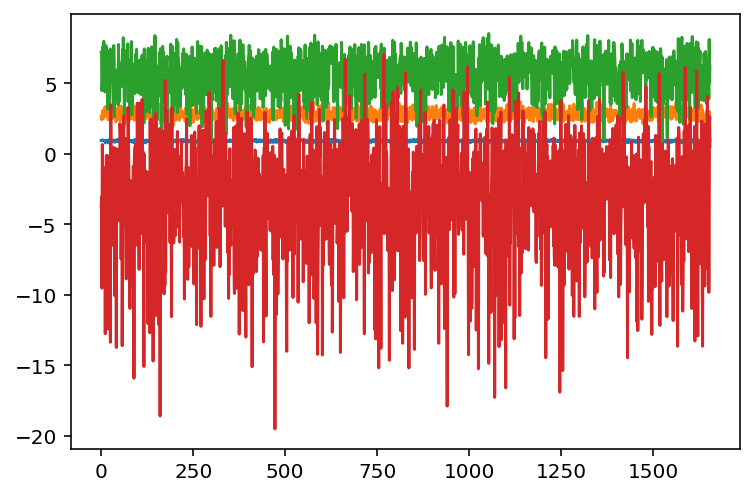

In [132]:
plt.plot(parameters)

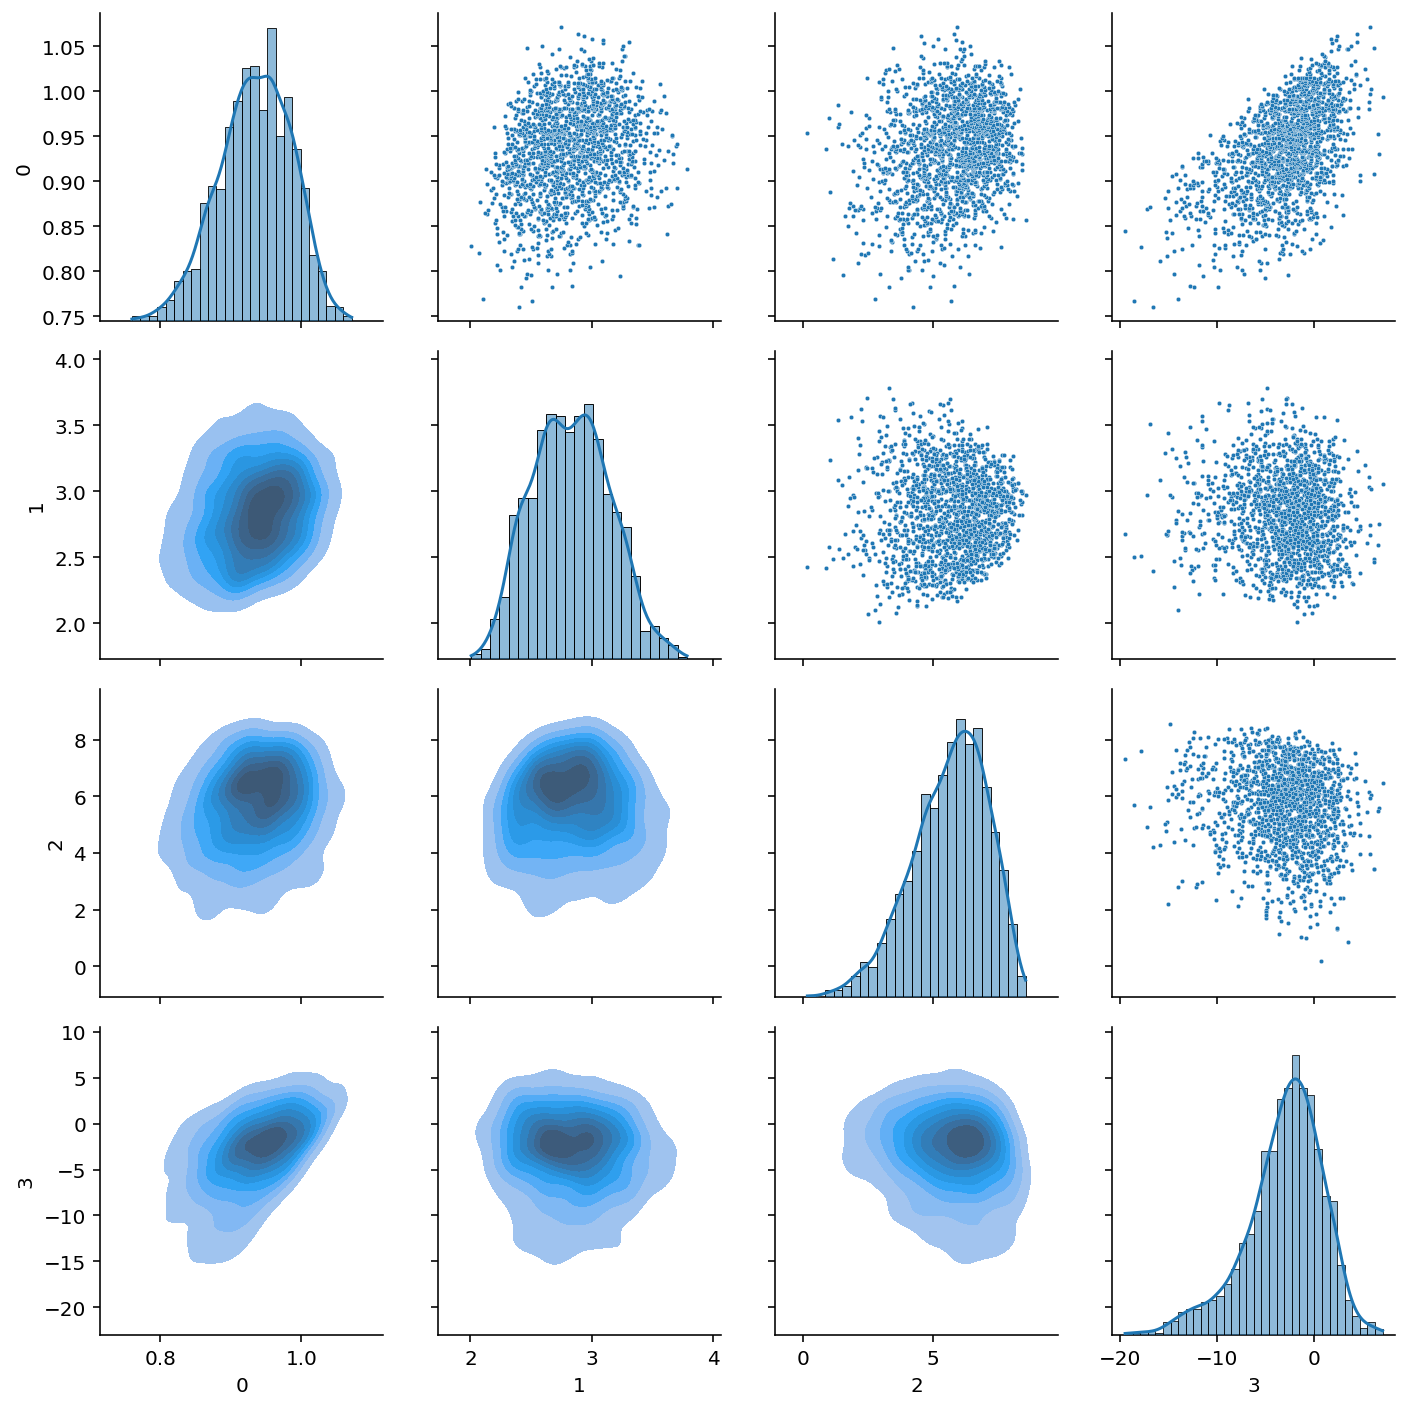

In [133]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

<AxesSubplot:title={'center':'x'}>

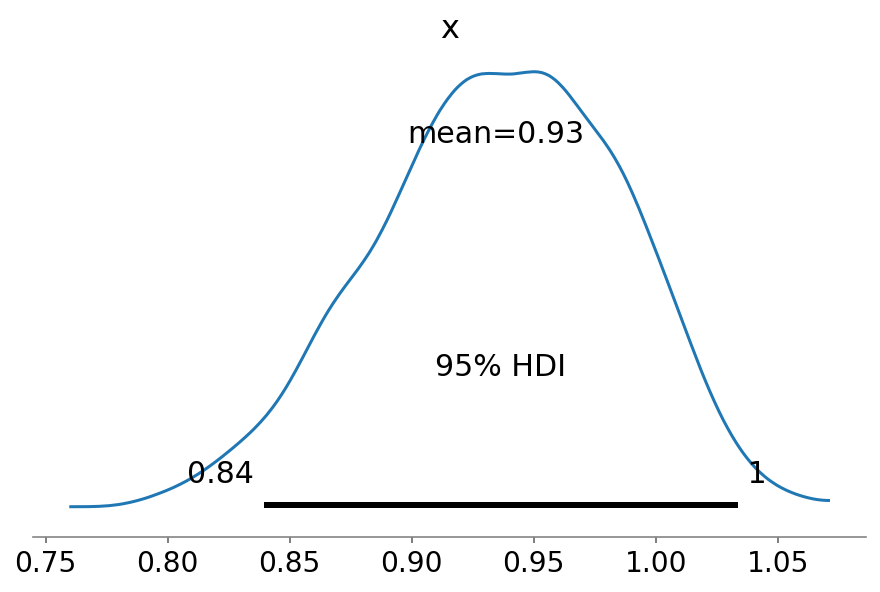

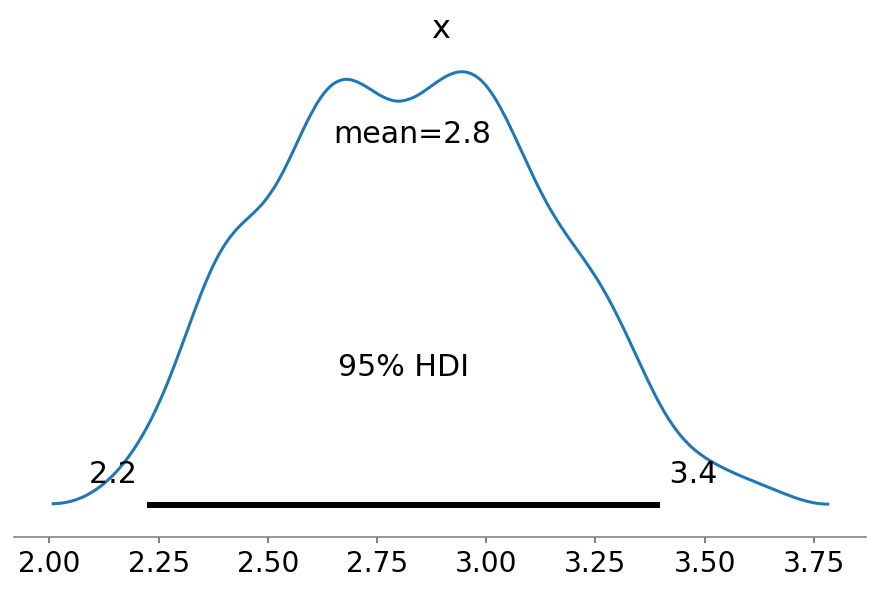

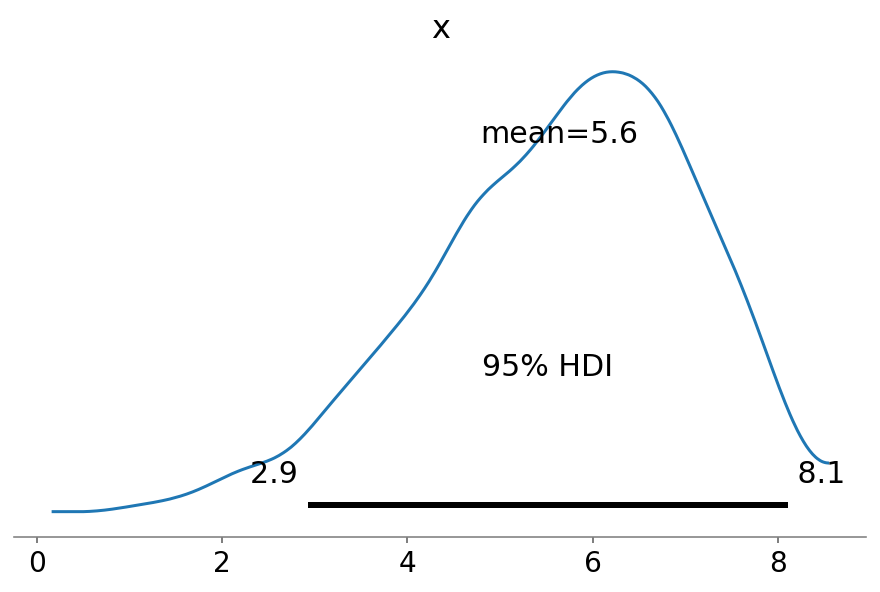

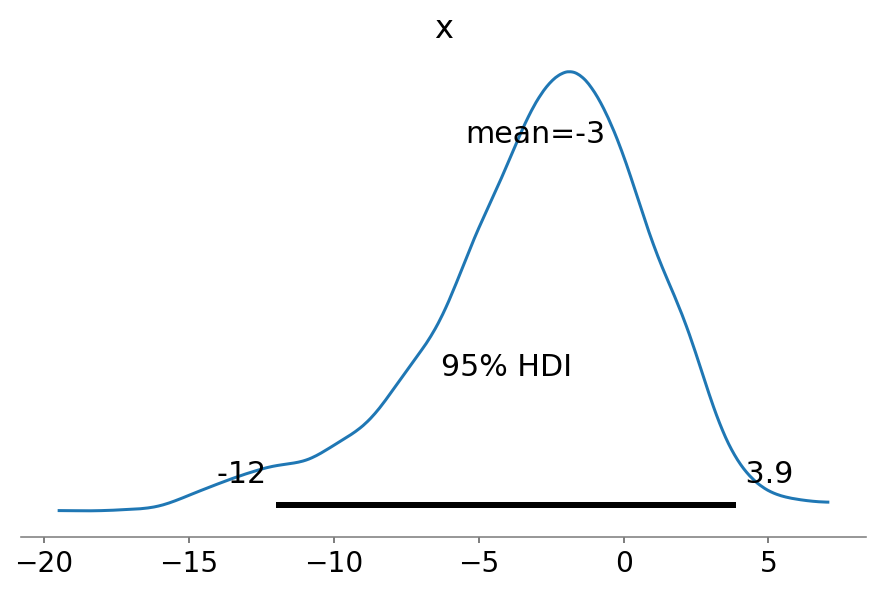

In [134]:
import arviz as az

az.plot_posterior(parameters[:,0],hdi_prob = 0.95)
az.plot_posterior(parameters[:,1],hdi_prob = 0.95)
az.plot_posterior(parameters[:,2],hdi_prob = 0.95)
az.plot_posterior(parameters[:,3],hdi_prob = 0.95)

In [159]:
#np.save('parameters_new.npy',parameters)
#np.save('weights_new.npy',weights)

In [690]:
#parameters = np.load('parameters_new.npy')
#weights = np.load('weights_new.npy')

100%|█████████████████████████████████████████████████████████████████████████████| 1655/1655 [00:03<00:00, 472.41it/s]


72633.75445149896 121995.22349045552
28 41
44


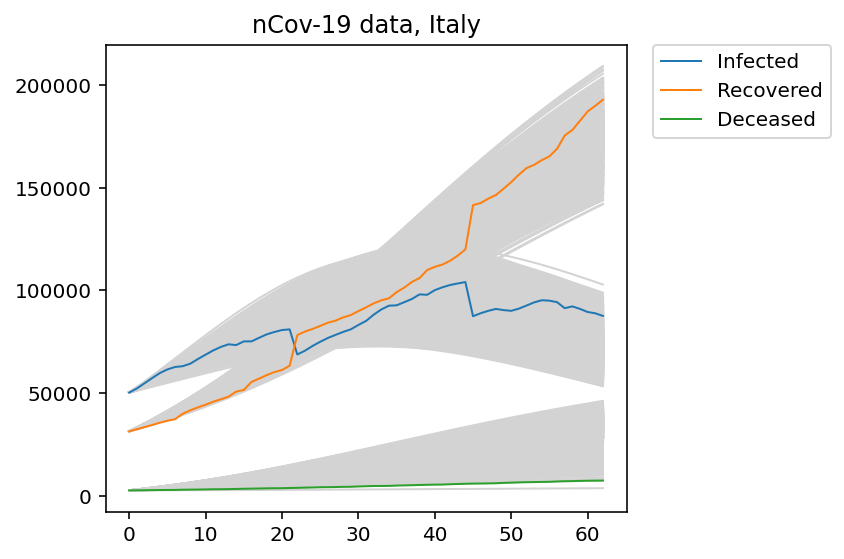

In [135]:
peak = []
day_peak = []

trajectories2storeI = np.zeros(shape=(parameters.shape[0], ext))
trajectories2storeR = np.zeros(shape=(parameters.shape[0], ext))
trajectories2storeD = np.zeros(shape=(parameters.shape[0], ext))

for j in tqdm(range(parameters.shape[0])):
    simul_yy = odeint(SIRD_reduced_30_new, italy_start, np.arange(ext), args=tuple(parameters[j]))
    trajectories2storeI[j,:] = simul_yy[:,0]
    trajectories2storeR[j,:] = simul_yy[:,1]
    trajectories2storeD[j,:] = simul_yy[:,2]
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0]))
    
plot_traj_SIRD(extended_y)

print(min(peak), max(peak))
print(min(day_peak), max(day_peak))
print(np.argmax(extended_y[:,0]))

plt.show()

In [141]:
# Test for
#  H0: alpha >= 0
#  H1: alpha < 0

p0 = np.sum(parameters[:,3] <= 0)/parameters.shape[0]
BF10 = p0/(1-p0)

print(2*np.log(BF10))

'''
There's a slight evidence in favour of H0
'''

2.5960035079484247


"\nThere's a slight evidence in favour of H0\n"

In [142]:
sps.ttest_1samp(parameters[:,3], 0, alternative='less')

Ttest_1sampResult(statistic=-31.142081983934478, pvalue=2.9949874266835723e-168)

In [143]:
np.save('parameters_veneto.npy',parameters)
np.save('weights_veneto.npy',weights)
np.savetxt("parsVeneto.csv", parameters, delimiter=",")
np.savetxt("trajIVeneto.csv", trajectories2storeI, delimiter=",")
np.savetxt("trajRVeneto.csv", trajectories2storeR, delimiter=",")
np.savetxt("trajDVeneto.csv", trajectories2storeD, delimiter=",")

In [144]:
parlomb = np.load('parameters_lombardia.npy')

In [145]:
sps.mannwhitneyu(parameters[:,3], parlomb[:,3], alternative='less')

MannwhitneyuResult(statistic=362303.0, pvalue=1.225469536480402e-301)

In [178]:
fin_beta_lomb = parlomb[:,0]/10*np.exp((-parlomb[:,3]*ext/1000))
fin_beta_veneto =  parameters[:,0]/10*np.exp((-parameters[:,3]*ext/1000))

print(fin_beta_veneto)

sps.mannwhitneyu(fin_beta_lomb, fin_beta_veneto, alternative='greater')

[0.12108167 0.11621561 0.17269237 ... 0.12943522 0.08097181 0.09421942]


MannwhitneyuResult(statistic=1901583.0, pvalue=7.363472462296536e-73)

In [182]:
fin_beta_lomb = parlomb[:,0]/10*np.exp((-parlomb[:,3]*88/1000))
fin_beta_veneto =  parameters[:,0]/10*np.exp((-parameters[:,3]*88/1000))

print(fin_beta_veneto)

sps.mannwhitneyu(fin_beta_lomb, fin_beta_veneto, alternative='greater')

[0.13304335 0.12536879 0.2191005  ... 0.14424929 0.07578035 0.0929372 ]


MannwhitneyuResult(statistic=1437226.0, pvalue=0.08263025708508837)